In [61]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import json
from ast import literal_eval
import re
import ast


In [62]:
# Load the stereotype dictionary
dictionary = "Create Dictionary/Stereotype_Dictionary.json"
with open(dictionary, 'r') as f:
    stereotype_dict = json.load(f)

stereotype_df = pd.DataFrame(list(stereotype_dict.items()), columns=['category', 'word'])
stereotype_df = stereotype_df.explode("word")
stereotype_df["word"] = stereotype_df["word"].str.lower()

stereotype_list = stereotype_df.word.tolist()

stereotype_df.head()

def load_word2vec_model(File):
    print("Loading Glove Model")
    word2vec_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0].lower().strip()
            if word in stereotype_list:
                embedding = np.array(split_line[1:], dtype=np.float64)
                embedding = np.round(embedding, 10)
                word2vec_model[word] = embedding
    print(f"{len(word2vec_model)} words loaded!")
    word2vec_df = pd.DataFrame(list(word2vec_model.items()), columns=['word', 'vector'])
    merged_df = word2vec_df.merge(stereotype_df, on="word")
    return merged_df

In [63]:
word2vec_after_vecs = load_word2vec_model("Tokenized Data/After_word2vec_vectors.txt")
word2vec_before_vecs = load_word2vec_model("Tokenized Data/Before_word2vec_vectors.txt")

BERT_after_vecs = pd.read_csv("Tokenized Data/BERT_After_word_vectors.csv")
BERT_before_vecs = pd.read_csv("Tokenized Data/BERT_Before_word_vectors.csv")

BERT_after_vecs = BERT_after_vecs.merge(stereotype_df, on="word")
BERT_before_vecs = BERT_before_vecs.merge(stereotype_df, on="word")

BERT_after_vecs.head()
# sterotypes_df = pd.read_csv("Create Dictionary/word2vec_Stereotype_word_embeddings.csv")
# sterotypes_df.head()

def fix_format(vector_str):
    # Add a comma between numbers using regex
    fixed_str = re.sub(r"(?<=[0-9])\s+(?=-?\d)", ", ", vector_str)
    return fixed_str


def safe_literal_eval(vector_str):
    try:
        return ast.literal_eval(vector_str)
    except Exception as e:
        print(f"Error evaluating: {vector_str} | Error: {e}")
        return np.nan
    
BERT_after_vecs["vector"] = BERT_after_vecs["vector"].apply(fix_format)
BERT_after_vecs["vector"] = BERT_after_vecs["vector"].apply(safe_literal_eval)
BERT_before_vecs["vector"] = BERT_before_vecs["vector"].apply(fix_format)
BERT_before_vecs["vector"] = BERT_before_vecs["vector"].apply(safe_literal_eval)

#Round the vector by 10 decimal
BERT_after_vecs["vector"] = BERT_after_vecs["vector"].apply(
    lambda x: np.round(np.array(x), decimals=10).tolist() if isinstance(x, list) else x
)
BERT_before_vecs["vector"] = BERT_before_vecs["vector"].apply(
    lambda x: np.round(np.array(x), decimals=10).tolist() if isinstance(x, list) else x
)

# BERT_after_vecs.head()

Loading Glove Model
158 words loaded!
Loading Glove Model
28 words loaded!


In [64]:
def visualize_vector_changes(before_df, after_df, 
                              vector_column='vector', 
                              word_column='word', 
                              category_column='category',
                              top_n_words=10,
                              highlight_words=None):
    """
    Visualize changes in word vectors for top words in each category.
    
    Parameters:
    -----------
    before_df : pandas.DataFrame
        Initial DataFrame with words and their original vectors
    after_df : pandas.DataFrame
        Updated DataFrame with words and their new vectors
    vector_column : str, optional (default='vector')
        Name of the column containing word vectors
    word_column : str, optional (default='word')
        Name of the column containing words
    category_column : str, optional (default='category')
        Name of the column containing category labels
    top_n_words : int, optional (default=10)
        Number of top words to select from each category
    highlight_words : list, optional
        List of words to emphasize with larger, bolder points
    
    Returns:
    --------
    matplotlib.figure.Figure
        Figure showing vector changes for top words
    """
    # Function to get top N words per category
    def get_top_words(df, n=10):
        # Count word frequencies per category
        word_counts = df.groupby(category_column)[word_column].value_counts()
        
        # Get top N words for each category
        top_words_per_category = {}
        for category in df[category_column].unique():
            top_category_words = word_counts[category].nlargest(n).index.tolist()
            top_words_per_category[category] = top_category_words
        
        return top_words_per_category

    # Get top words from both dataframes
    before_top_words = get_top_words(before_df, top_n_words)
    after_top_words = get_top_words(after_df, top_n_words)
    
    # Combine top words from both dataframes
    all_top_words = set()
    for category, words in before_top_words.items():
        all_top_words.update(words)
    for category, words in after_top_words.items():
        all_top_words.update(words)
    
    # Filter DataFrames to include only top words
    before_filtered = before_df[before_df[word_column].isin(all_top_words)].copy()
    after_filtered = after_df[after_df[word_column].isin(all_top_words)].copy()
    
    # Ensure vectors are in the right format
    def convert_to_array(df):
        if isinstance(df[vector_column].iloc[0], str):
            return np.array([eval(vec) for vec in df[vector_column]])
        return np.array(df[vector_column].tolist())
    
    # Find common words between before and after DataFrames
    common_words = list(set(before_filtered[word_column]) & set(after_filtered[word_column]))
    
    # Prepare vectors for common words only
    before_common = before_filtered[before_filtered[word_column].isin(common_words)]
    after_common = after_filtered[after_filtered[word_column].isin(common_words)]
    
    # Convert vectors for common words
    before_vectors = convert_to_array(before_common)
    after_vectors = convert_to_array(after_common)
    
    # Combine vectors for t-SNE
    combined_vectors = np.vstack([before_vectors, after_vectors])
    
    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    combined_2d = tsne.fit_transform(combined_vectors)
    
    # Split t-SNE results
    before_2d = combined_2d[:len(before_vectors)]
    after_2d = combined_2d[len(before_vectors):]
    
    # Create visualization
    plt.figure(figsize=(16, 12))
    
    # Prepare color palette based on categories
    categories = pd.concat([before_common, after_common])[category_column].unique()
    color_palette = plt.cm.get_cmap('tab10')
    category_colors = {cat: color_palette(i/len(categories)) for i, cat in enumerate(categories)}
    
    # Plot and connect common words
    def vector_change_color(before_vec, after_vec):
        change = np.linalg.norm(np.array(before_vec) - np.array(after_vec))
        return plt.cm.RdYlGn_r(min(change / 2, 1))
    
    # If no highlight words specified, use words of interest from before
    if highlight_words is None:
        highlight_words = ["hamas", "idf", "muslim", "jewish", "israeli", "arabic"]
    
    for word in common_words:
        # Find indices in the filtered DataFrames
        before_idx = before_common.index[before_common[word_column] == word].tolist()[0]
        after_idx = after_common.index[after_common[word_column] == word].tolist()[0]
        
        # Get points from t-SNE results
        before_point = before_2d[before_common.index.get_loc(before_idx)]
        after_point = after_2d[after_common.index.get_loc(after_idx)]
        
        # Get category for color
        category = before_common.loc[before_idx, category_column]
        color = category_colors[category]
        
        # Determine vector change color
        before_vec = before_common.loc[before_idx, vector_column]
        after_vec = after_common.loc[after_idx, vector_column]
        change_color = vector_change_color(before_vec, after_vec)
        
        # Plot connection line
        plt.plot([before_point[0], after_point[0]], 
                 [before_point[1], after_point[1]], 
                 color=change_color, alpha=0.3, linestyle='--')
        
        # Check if word should be highlighted
        if word.lower() in [w.lower() for w in highlight_words]:
            # Larger, bolder point for highlighted words
            plt.scatter(before_point[0], before_point[1], color=color, alpha=0.7, 
                        s=200, edgecolors='black', linewidth=2)
            plt.scatter(after_point[0], after_point[1], color=color, alpha=0.7, 
                        s=200, edgecolors='black', linewidth=2)
            # Bold annotation for highlighted words
            plt.annotate(f'{word} (before)', (before_point[0], before_point[1]), 
                         xytext=(5, 2), textcoords='offset points', 
                         fontsize=10, fontweight='bold', alpha=1)
            plt.annotate(f'{word} (after)', (after_point[0], after_point[1]), 
                         xytext=(5, 2), textcoords='offset points', 
                         fontsize=10, fontweight='bold', alpha=1)
        else:
            # Normal plotting for other words
            plt.scatter(before_point[0], before_point[1], color=color, alpha=0.7)
            plt.scatter(after_point[0], after_point[1], color=color, alpha=0.7)
            plt.annotate(f'{word} (before)', (before_point[0], before_point[1]), 
                         xytext=(5, 2), textcoords='offset points', fontsize=8, alpha=0.7)
            plt.annotate(f'{word} (after)', (after_point[0], after_point[1]), 
                         xytext=(5, 2), textcoords='offset points', fontsize=8, alpha=0.7)
    
    plt.title('Word Vector Changes for Top Words by Category')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.tight_layout()
    # plt.savefig('BERT_vectors_change.png', format='png')

    
    return plt

C:\Users\nhath\AppData\Local\Temp\ipykernel_17640\2445696106.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab10')


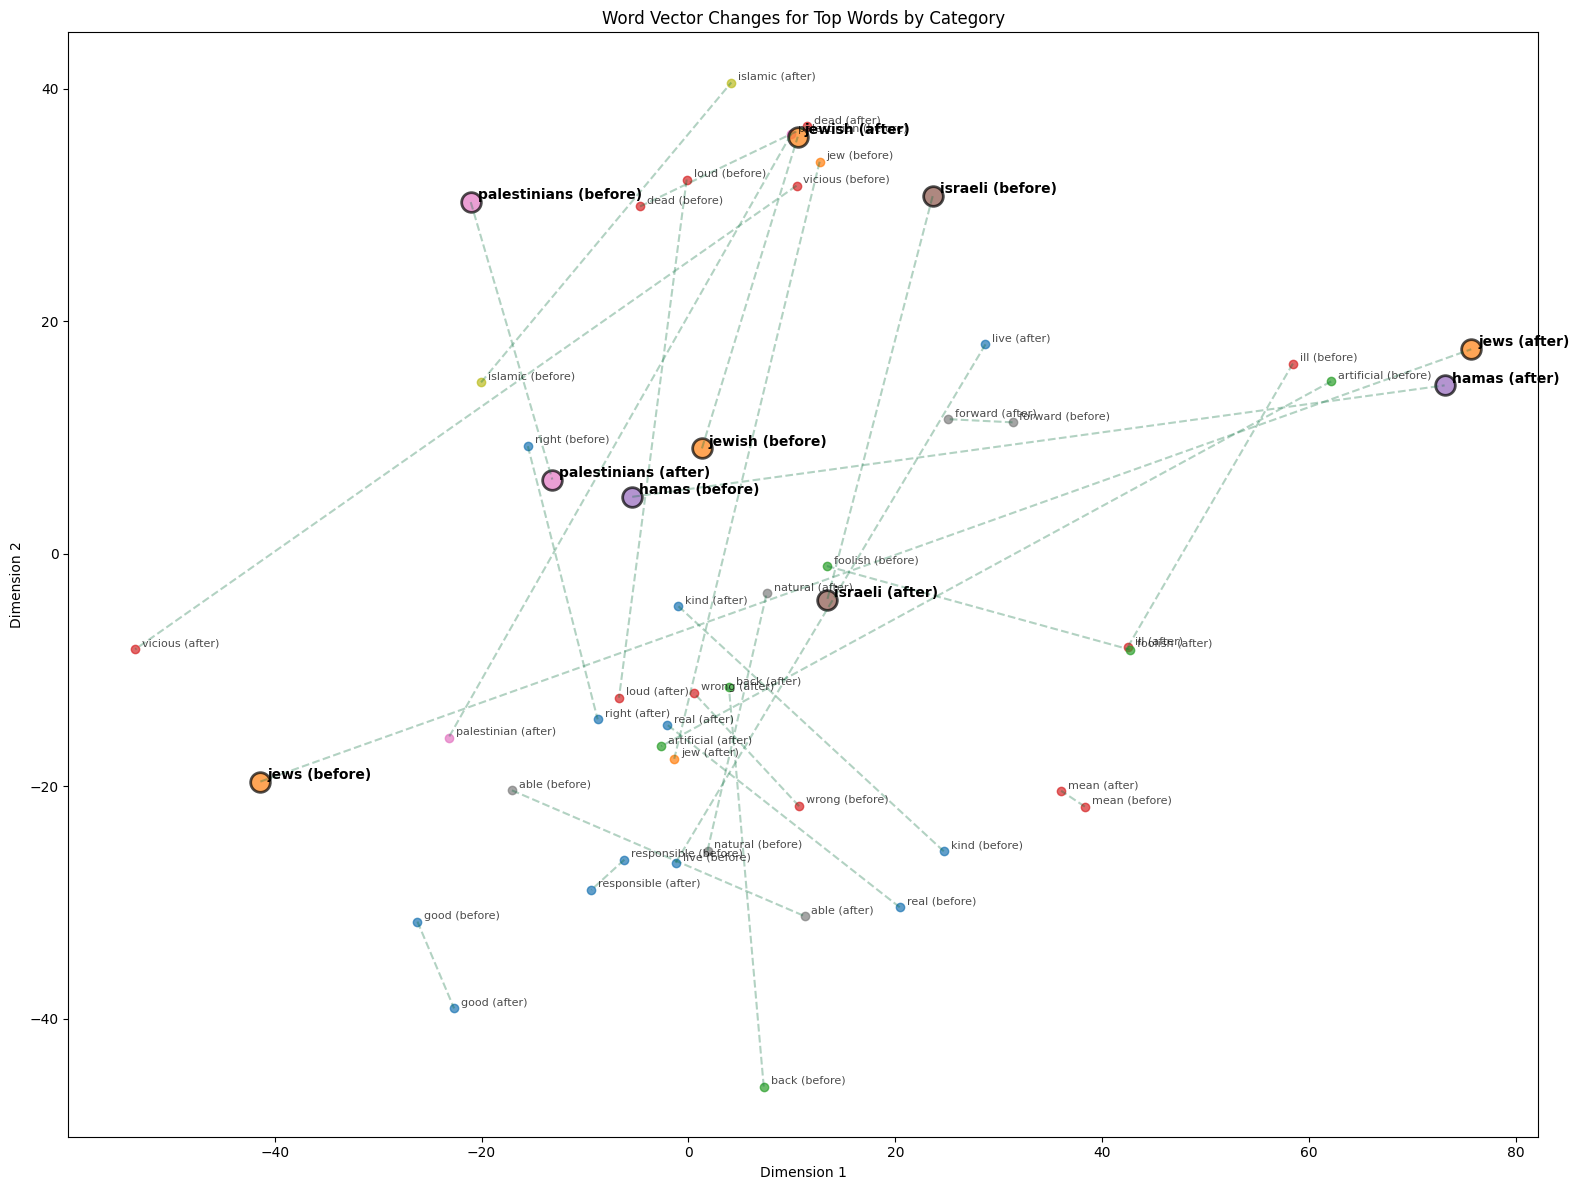

In [65]:

# fig = visualize_vector_changes(BERT_before_vecs, BERT_after_vecs)
fig = visualize_vector_changes(
    BERT_before_vecs, 
    BERT_after_vecs, 
    top_n_words=50,  # Change to top 5 words per category
    highlight_words=["hamas", "idf", "muslim", "jewish", "israelis", "palestinians", "israeli", "jews"]
)
plt.savefig('BERT_vectors_change.png', format='png')
fig.show()

C:\Users\nhath\AppData\Local\Temp\ipykernel_17640\2445696106.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab10')


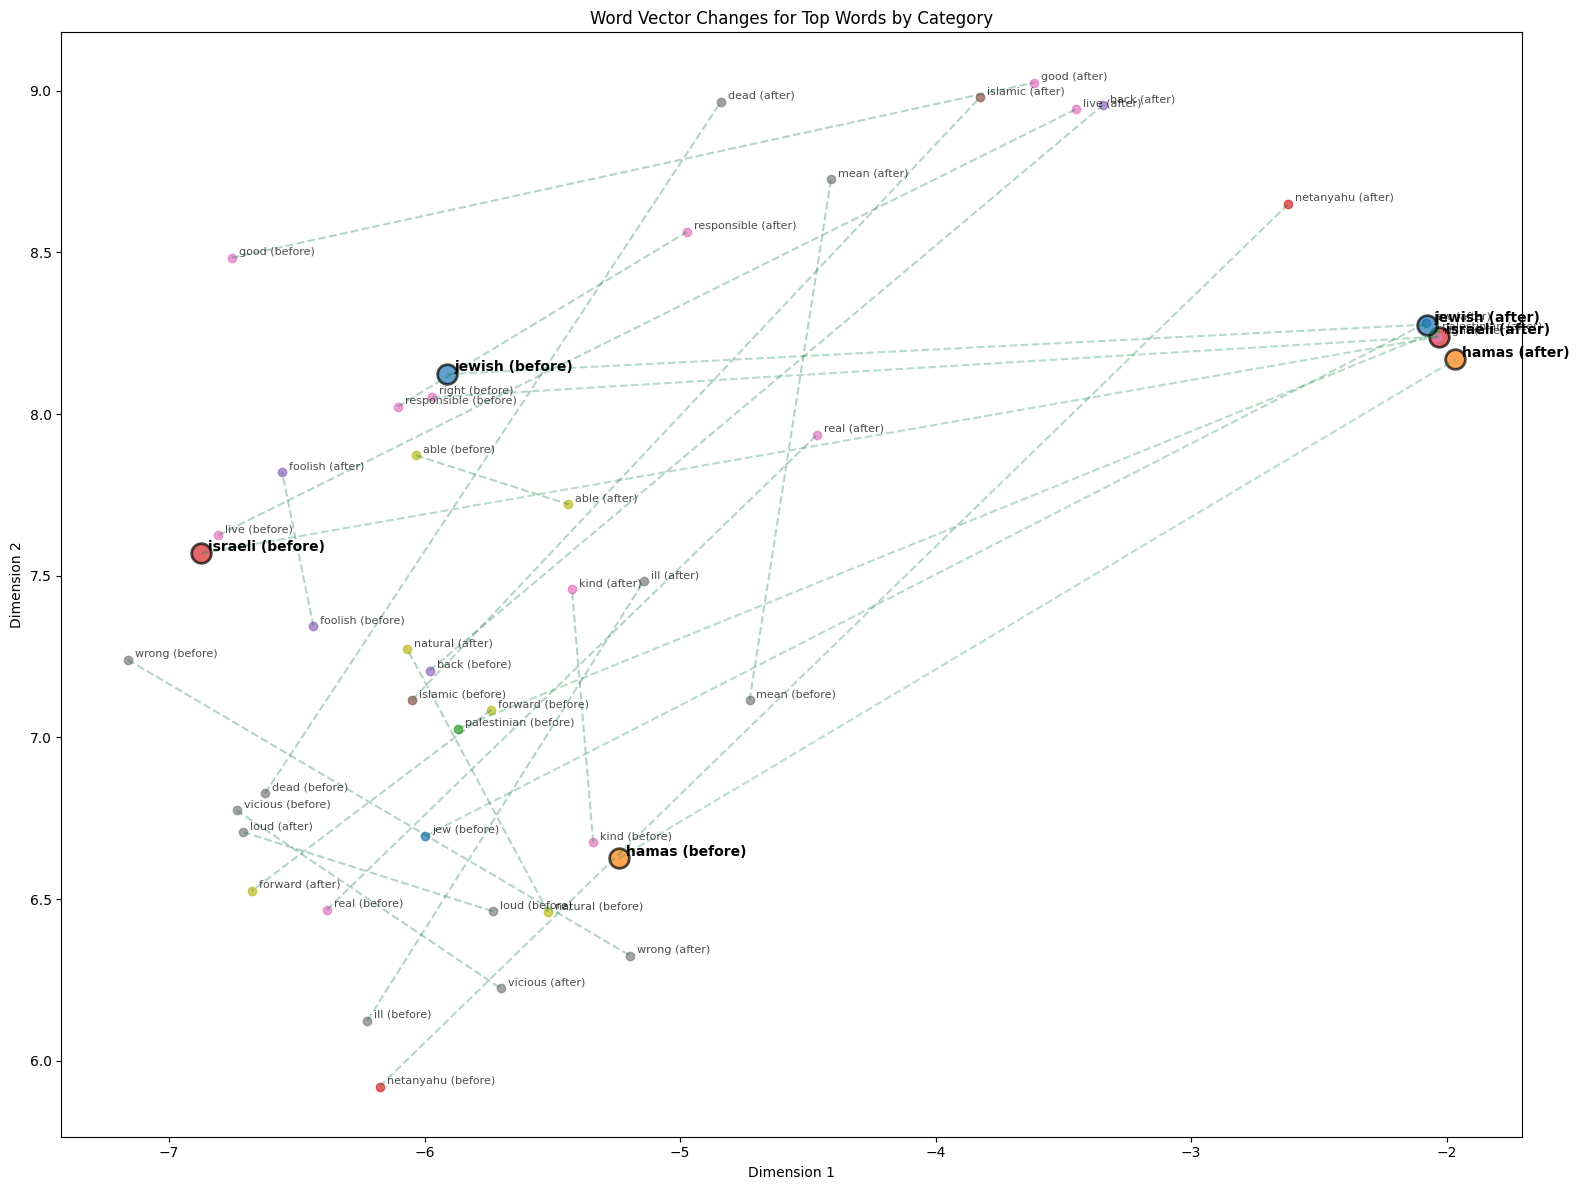

In [66]:

# fig = visualize_vector_changes(BERT_before_vecs, BERT_after_vecs)
fig = visualize_vector_changes(
    word2vec_before_vecs, 
    word2vec_after_vecs, 
    top_n_words=50,  # Change to top 5 words per category
    highlight_words=["hamas", "idf", "muslim", "jewish", "israelis", "palestinians", "israeli", "jews"]
)
plt.savefig('word2vec_vectors_change.png', format='png')
fig.show()